In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
from matplotlib import cm as cm

In [18]:
filepath = "./data/processed_production_data.csv"
df_post_peak = pd.read_csv(filepath, low_memory=False)

prod_filepath = "./data/production_data.csv"
df_prod = pd.read_csv(prod_filepath, low_memory=False)

# alias_filepath = "./data/operator_aliasing.csv"
# df_alias = pd.read_csv(alias_filepath, low_memory=False)

wells_filepath = "./data/processed_wells_data.csv"
df_wells = pd.read_csv(wells_filepath, low_memory=False)

## Plot 1 - Production Type Curve Per Basin

In [19]:
def plot_prod_curve(basin_data_pre, basin_data_post, y_label):
    data_pre = basin_data_pre.apply(lambda x: x.values.tolist()).tolist()
    data_post = basin_data_post.apply(lambda x: x.values.tolist()).tolist()
    
    mean_pre = basin_data_pre.apply(lambda x: np.mean(x.values)).tolist()
    mean_post = basin_data_post.apply(lambda x: np.mean(x.values)).tolist()
    
    median_pre = basin_data_pre.apply(lambda x: np.median(x.values)).tolist()
    median_post = basin_data_post.apply(lambda x: np.median(x.values)).tolist()
    
    p90_pre = basin_data_pre.apply(lambda x: np.percentile(x.values, 90)).tolist()
    p90_post = basin_data_post.apply(lambda x: np.percentile(x.values, 90)).tolist()
    
    x = np.arange(1,37).tolist()
        
    fig = plt.figure(constrained_layout=True, figsize=(13,3))
    spec = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)

    
    f_ax1 = fig.add_subplot(spec[0, 0])
    f_ax2 = fig.add_subplot(spec[0, 1])
    
    f_ax1.yaxis.set_ticks(np.arange(0, 40000, 5000))
    f_ax1.set_ylim(0,37000)
    f_ax1.set_title('Before 2014')
    f_ax1.set_ylabel(y_label)
    f_ax1.boxplot(data_pre, showfliers=False)
    f_ax1.plot(x, p90_pre, color='steelblue', label='90th Percentile')
    f_ax1.plot(x, mean_pre, color='orange', label='Mean')
    f_ax1.plot(x, median_pre, color='green', label='Median')
    f_ax1.legend(loc="upper right")
    
    f_ax2.yaxis.set_ticks(np.arange(0, 40000, 5000))
    f_ax2.set_ylim(0,37000)
    f_ax2.set_title('After 2014')
    f_ax2.boxplot(data_post, showfliers=False)
    f_ax2.plot(x, p90_post, color='steelblue', label='90th Percentile')
    f_ax2.plot(x, mean_post, 'orange', label='Mean')
    f_ax2.plot(x, median_post, color='green', label='Median')
    f_ax2.legend(loc="upper right")

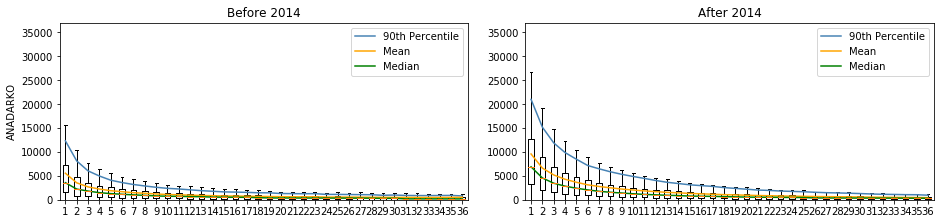

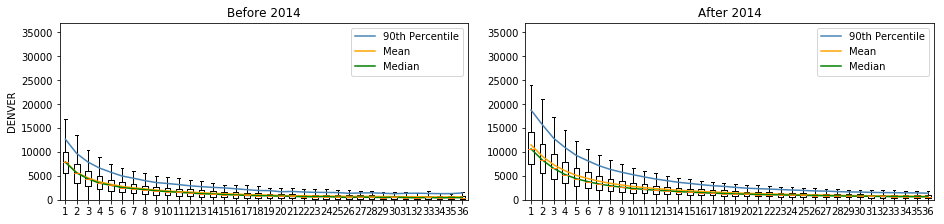

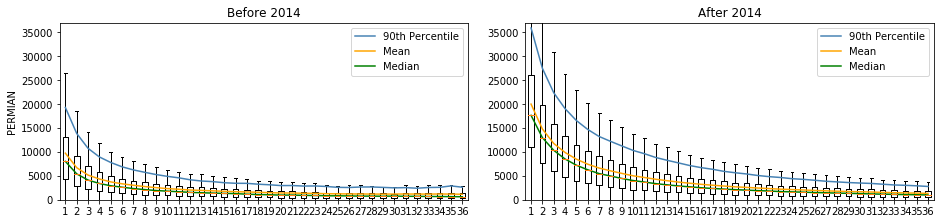

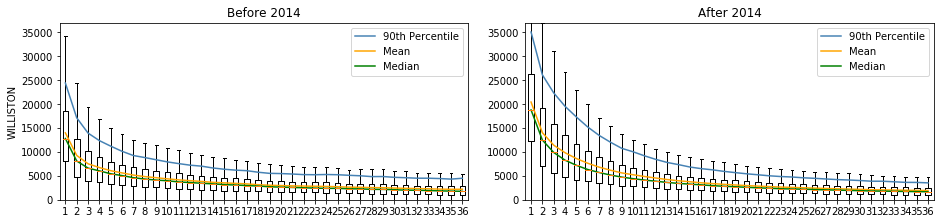

In [20]:
basin_names = ['ANADARKO BASIN', 'DENVER BASIN', 'PERMIAN BASIN', 'WILLISTON BASIN']
for basin in basin_names:
    basin_post_peak = df_post_peak[np.logical_and(df_post_peak['MonthIdx']<37, df_post_peak['API'].isin(df_wells[df_wells['BasinName']==basin]['API']))]
    
    basin_post_peak_pre = basin_post_peak[basin_post_peak['Year']<2014]
    basin_post_peak_pre_dist = basin_post_peak_pre.groupby(['MonthIdx'])['Liquid']
    
    basin_post_peak_post = basin_post_peak[basin_post_peak['Year']>=2014]
    basin_post_peak_post_dist = basin_post_peak_post.groupby(['MonthIdx'])['Liquid']
    plot_prod_curve(basin_post_peak_pre_dist, basin_post_peak_post_dist, basin.split(' ')[0])

### Selecting wells with peak month at least 5 years old

In [21]:
basin_names = ['ANADARKO BASIN', 'DENVER BASIN', 'PERMIAN BASIN', 'WILLISTON BASIN']
to_remove = []
# to_remove=['35073256530000','35073256910000','35073256940000']
basins_cum = []
for basin in basin_names:
    included_wells = df_post_peak[
        np.logical_and(~ df_post_peak['API'].isin(to_remove),
        np.logical_and(
            df_post_peak['MonthIdx']==1,
            np.logical_or(
                df_post_peak['Year']<2014,
                np.logical_and(
                    df_post_peak['Year']==2014,
                    df_post_peak['Month']<2
                )
            )
        ))
    ]['API']

    basin_post_peak_five = df_post_peak[np.logical_and(df_post_peak['API'].isin(included_wells),df_post_peak['MonthIdx']<=60)]

    wells_api = df_wells[df_wells['BasinName']==basin ]['API']

    basins_cum.append(basin_post_peak_five[basin_post_peak_five['API'].isin(wells_api)])


## Plot 2 - Percentage of Oil Recovered Per Year

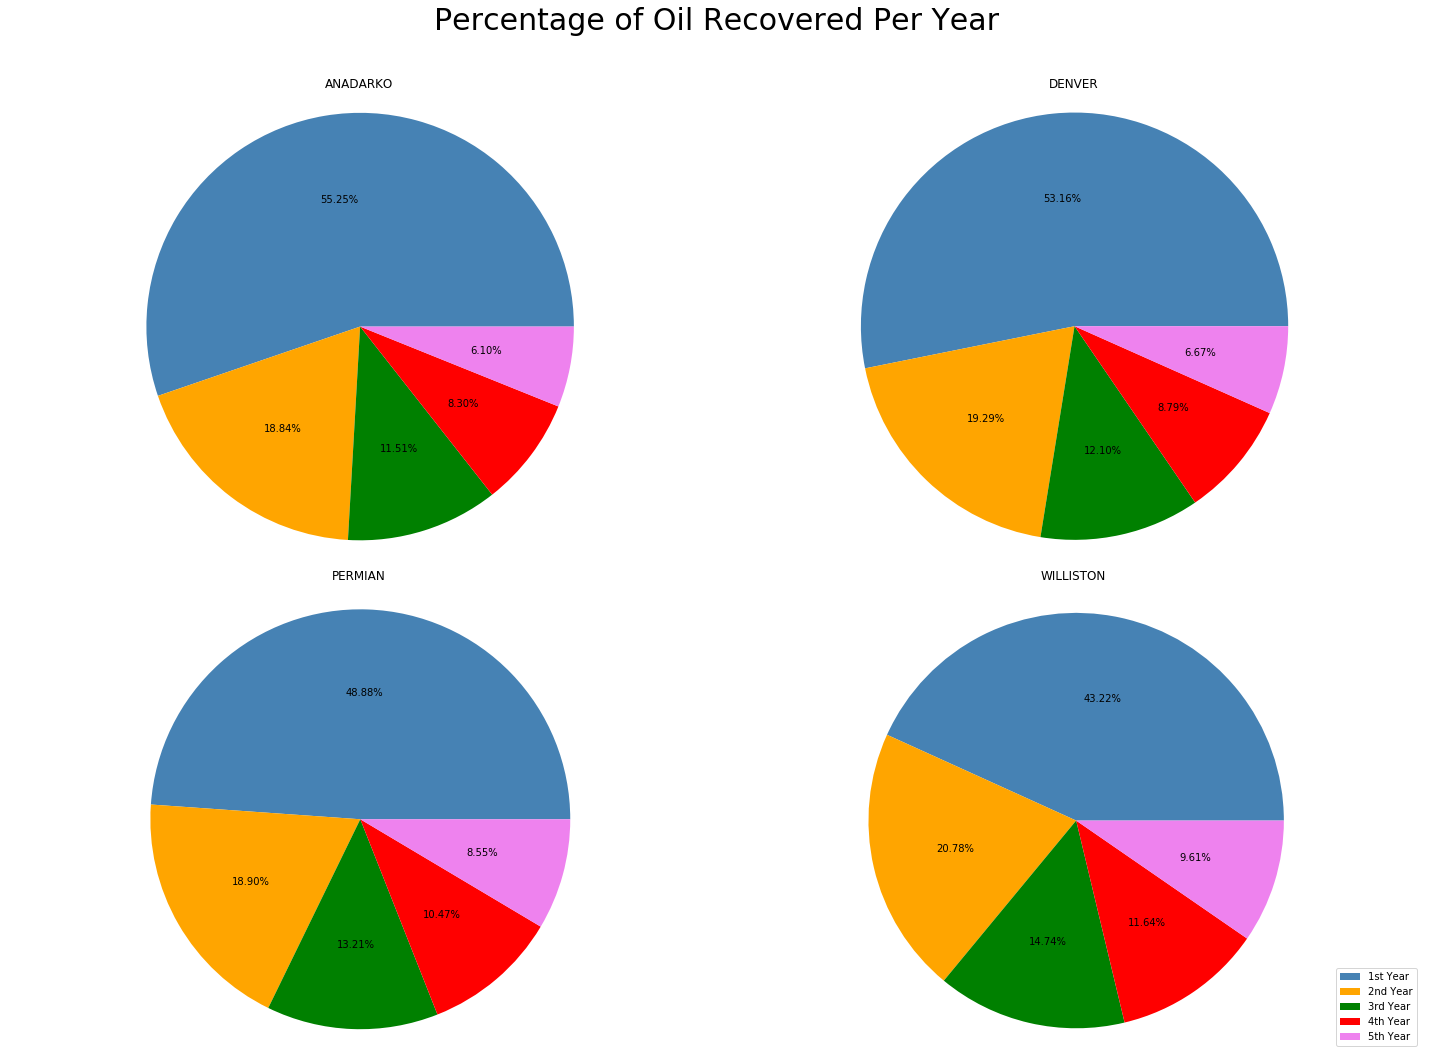

In [29]:
locations = [(0,0),(0,1),(1,0),(1,1)]

fig = plt.figure(figsize=(20,15))
fig.suptitle("Percentage of Oil Recovered Per Year", fontsize=30)

for idx in range(0,4):
    basin_post_peak_five = basins_cum[idx]
    total = basin_post_peak_five['Liquid'].sum()
    data=[]
    for year in range(1,6):
        data.append(basin_post_peak_five[
                np.logical_and(
                    basin_post_peak_five['MonthIdx']<=year*12, 
                    basin_post_peak_five['MonthIdx']>(year-1)*12
                )
        ]['Liquid'].sum()/total)


    colors = ['steelblue', 'orange', 'green', 'red', 'violet']
    labels = ['1st Year', '2nd Year', '3rd Year', '4th Year', '5th Year']
    
    ax = plt.subplot2grid((2,2),locations[idx])
    plt.pie(data, colors=colors, autopct='%1.2f%%')
    plt.title(basin_names[idx].split(' ')[0])
    plt.tight_layout()
    plt.axis('equal')
plt.legend(labels, loc="lower right")
plt.subplots_adjust(top=0.9)
 

## Plot 3 - Distribution of 5 Years Cum Production per basin

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


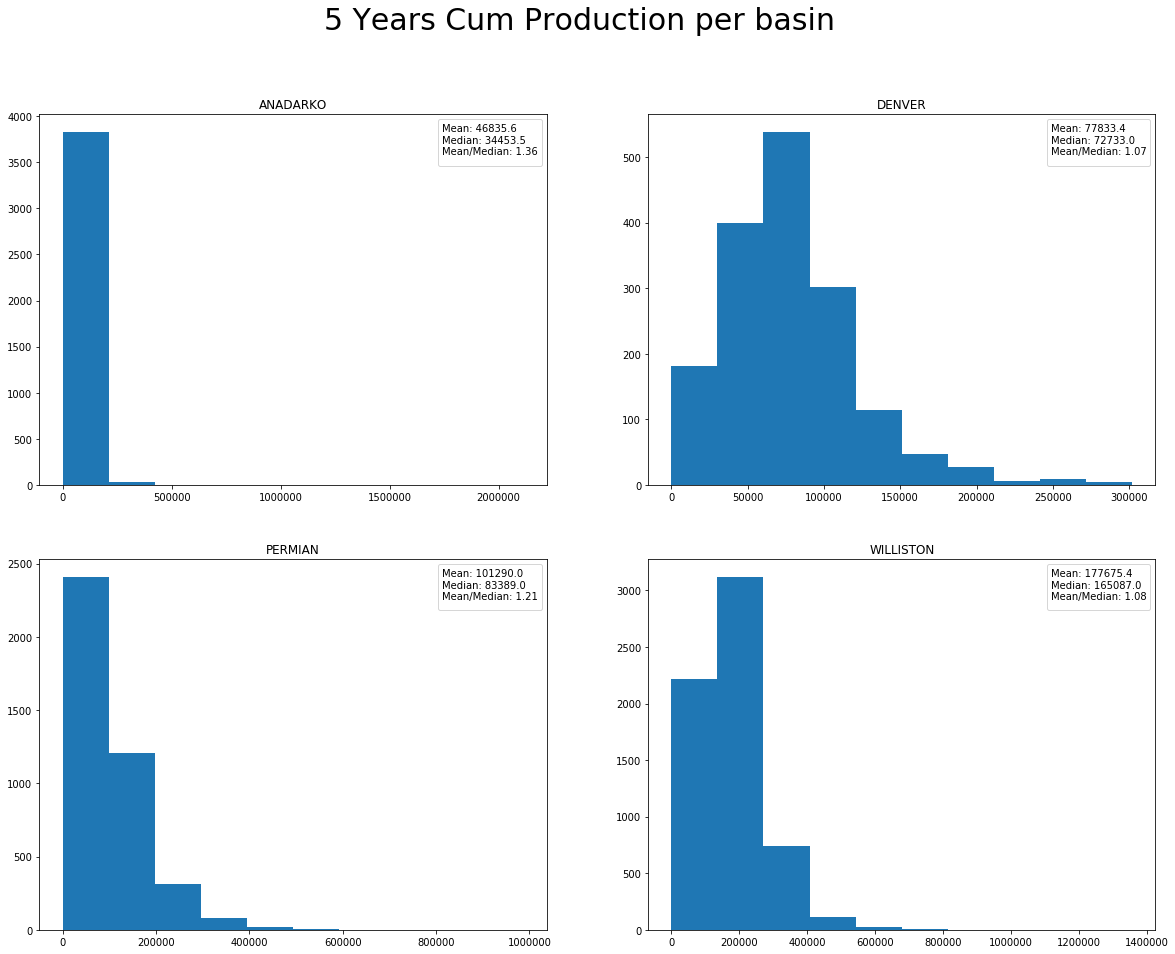

In [27]:
fig = plt.figure(figsize=(20,15))
fig.suptitle("5 Years Cum Production per basin", fontsize=30)
n_bins = 10

for idx in range(0,4):
    
    basin_post_peak_five = basins_cum[idx]
    wells_api = df_wells[df_wells['BasinName']==basin_names[idx]]['API']

    cum = basin_post_peak_five.groupby('API')['Liquid'].sum()
#     cum = cum[cum!=0]
    cum_mean = cum.mean()
    cum_median = cum.median()
    mean_median_ratio = cum_mean/cum_median
    
    ax = plt.subplot2grid((2,2),locations[idx])
    plt.title(basin_names[idx].split(' ')[0])
    ax.legend(title="Mean: "+str(round(cum_mean,1))+'\nMedian: '+str(round(cum_median,1))+'\nMean/Median: '+str(round(mean_median_ratio,2)))
#     ax.annotate(s="Mean: "+str(cum_mean), xy=(0.5,0.5),xycoords='axes fraction',fontsize=14)
    ax.hist(cum, bins=n_bins)
    

## Plot 4 - Correlation Between Oil and Gas Cum Production 

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


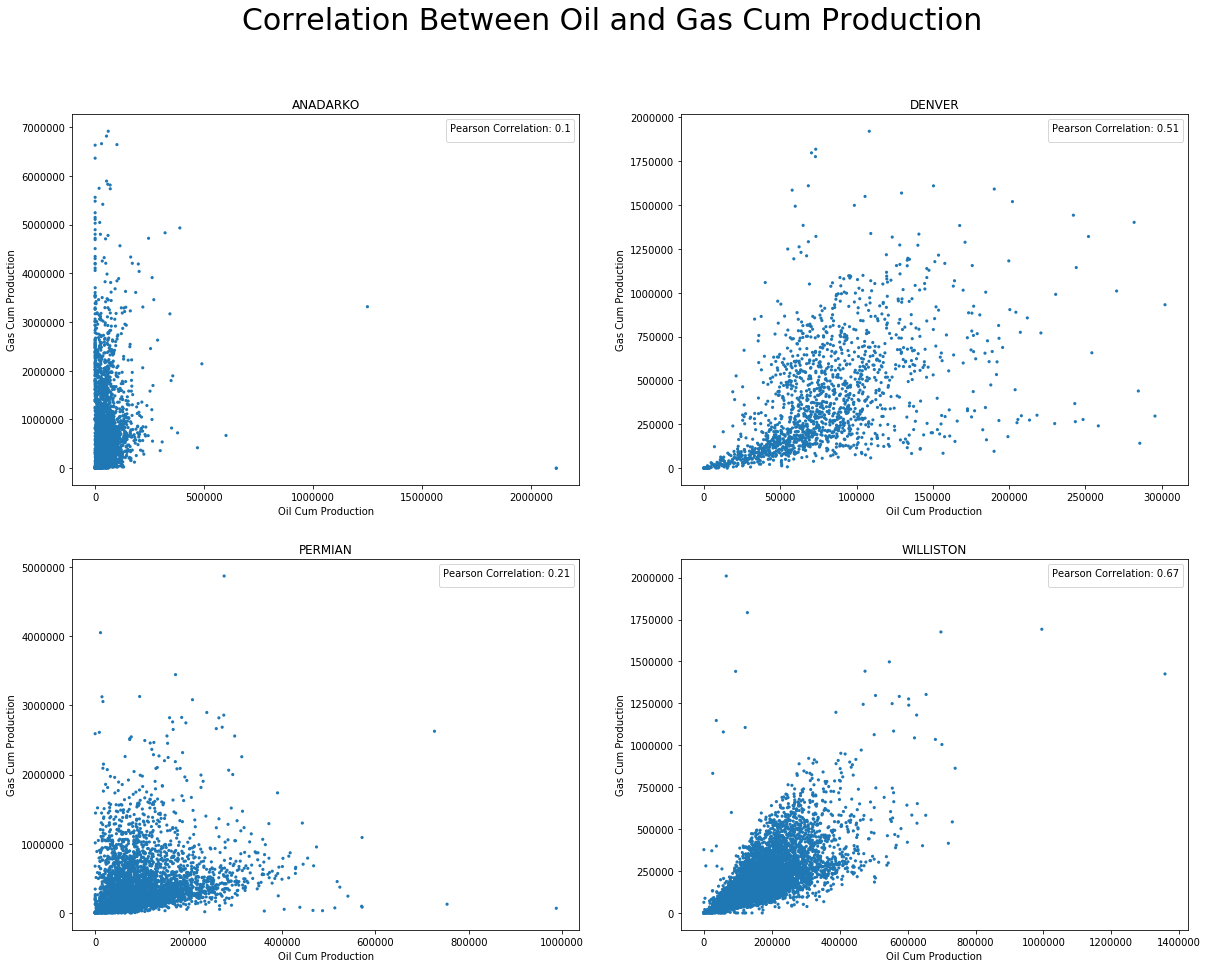

In [28]:
# basin_names=['PERMIAN BASIN']
fig = plt.figure(figsize=(20,15))
fig.suptitle("Correlation Between Oil and Gas Cum Production", fontsize=30)
for idx in range(0,4):
    five_year_wells = basins_cum[idx].sort_values(['API'])
    total_oil = five_year_wells.groupby('API')['Liquid'].sum()
    total_gas = five_year_wells.groupby('API')['Gas'].sum()
    pear_corr = np.corrcoef(total_oil,total_gas)[0,1]
    
    ax = plt.subplot2grid((2,2),locations[idx])
    plt.title(basin_names[idx].split(' ')[0])
    plt.xlabel("Oil Cum Production")
    plt.ylabel("Gas Cum Production")
    ax.legend(title="Pearson Correlation: "+str(round(pear_corr,2)))
    ax.scatter(total_oil, total_gas, edgecolors='none',s=10)
    

## Plot 5 - A Plot of Our Choice

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


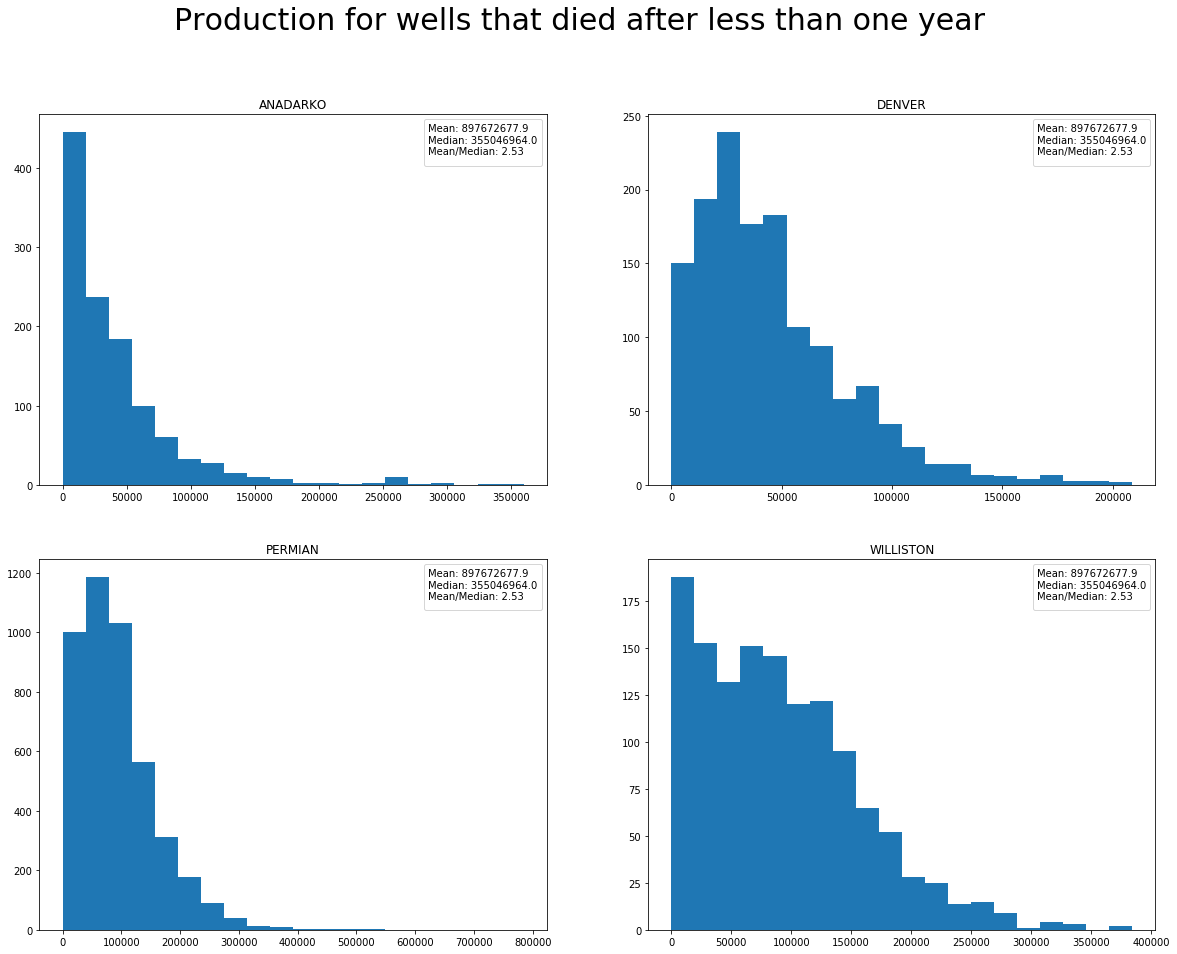

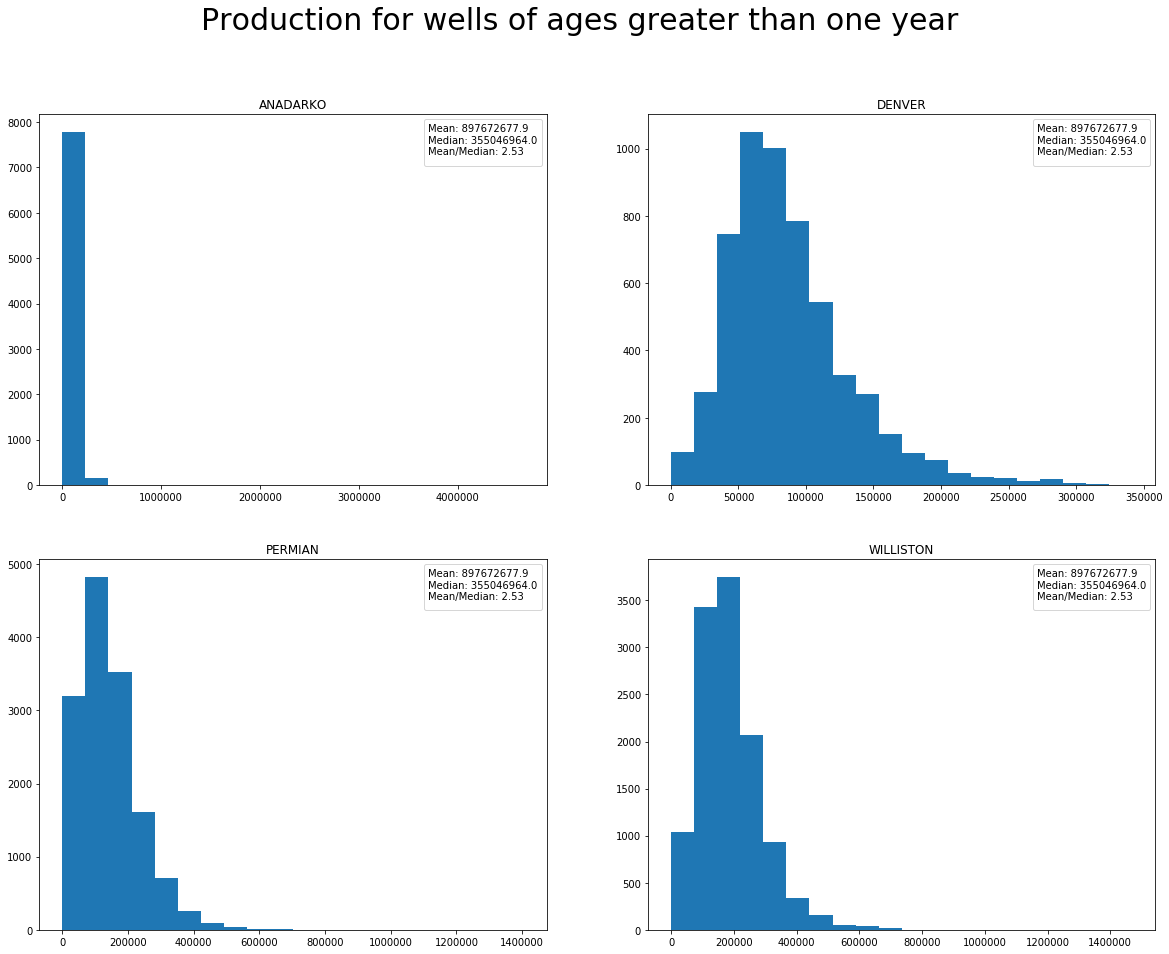

In [60]:
fig = plt.figure(figsize=(20,15))
fig.suptitle("Production for wells that died after less than one year", fontsize=30)
for idx in range(0,4):
    wells_api = df_wells[df_wells['BasinName']==basin_names[idx] ]['API']
    basin_post_peak = df_post_peak[df_post_peak['API'].isin(wells_api)]
    
    less_than_year = basin_post_peak[basin_post_peak.groupby('API')['MonthIdx'].transform(max)<=12]
    production = less_than_year.groupby('API')['Liquid'].sum()
    
    cum_mean = cum.mean()
    cum_median = cum.median()
    mean_median_ratio = cum_mean/cum_median
    
    ax = plt.subplot2grid((2,2),locations[idx])
    plt.title(basin_names[idx].split(' ')[0])
    ax.legend(title="Mean: "+str(round(cum_mean,1))+'\nMedian: '+str(round(cum_median,1))+'\nMean/Median: '+str(round(mean_median_ratio,2)))
    ax.hist(production, bins=20)

fig = plt.figure(figsize=(20,15))
fig.suptitle("Production for wells of ages greater than one year", fontsize=30)
for idx in range(0,4):
    wells_api = df_wells[df_wells['BasinName']==basin_names[idx] ]['API']
    basin_post_peak = df_post_peak[df_post_peak['API'].isin(wells_api)]
    
    less_than_year = basin_post_peak[basin_post_peak.groupby('API')['MonthIdx'].transform(max)>12]
    production = less_than_year.groupby('API')['Liquid'].sum()
    
    ax = plt.subplot2grid((2,2),locations[idx])
    plt.title(basin_names[idx].split(' ')[0])
    ax.legend(title="Mean: "+str(round(cum_mean,1))+'\nMedian: '+str(round(cum_median,1))+'\nMean/Median: '+str(round(mean_median_ratio,2)))
    ax.hist(production, bins=20)
    
    

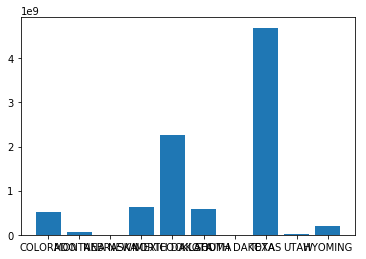

In [46]:
# fig = plt.figure()
# x = df_post_peak.merge(df_wells,on='API').sort_values('StateName')
# # print()
# cum = x.groupby('StateName')['Liquid'].sum()
# print(cum)
# cum.tolist()

ind = np.unique(x['StateName'])

ax = plt.bar(ind,cum)
# ax.hist(cum, )